## 1 Импорт библиотек и модулей

In [1]:
!pip install -q ydata_profiling

In [2]:
%matplotlib inline

In [3]:
# для работы с данными
import pandas as pd

# для EDA анализа
import ydata_profiling

# для визуализации
import matplotlib.pyplot as plt

## 2 Открытие файла с данными и изучение общей информации
Считаем данные из csv-файла в датафрейм, сохраним в переменную `df` и проведём EDA анализ.

In [4]:
def read_eda(name):
    try:
        df = pd.read_csv('/datasets/' + name + '.csv')
    except:
        df = pd.read_csv('https://code.s3.yandex.net/datasets/' + name + '.csv')
    ydata_profiling.ProfileReport(df, progress_bar=False).to_file(name + '.html')
    return df

In [5]:
df = read_eda('yandex_music_project')

[Посмотреть анализ.](https://www.dropbox.com/s/19w3fxjkoqzkfmp/yandex_music_project.html?dl=0)

- **В данных 65079 строк, 7 столбцов, тип данных: object.**  
- **Обнаружены некорректные названия столбцов.**
- **Присутствуют пропуски.**

<div style="border:solid steelblue 5px; padding: 30px">
<p>
        <b>После изучения данных, стала ясна их общая структура:</b> 65079 строк, 7 столбцов, тип данных: object.<br> <b>Также были обнаружены данные, подлежащие обработке:</b>
        <li>Названия столбцов.</li>
        <li>Пропуски.</li>
    </p>  
</div>

## 3 Предобработка данных
### 3.1 Переименование столбцов
Изменим названия столбцов `userID`, `Track`, `City` и `Day`.

In [6]:
df = df.rename(columns={'  userID':'user_id', 'Track':'track', '  City  ':'city', 'Day':'day'})

Проверим названия столбов.

In [7]:
df.columns

Index(['user_id', 'track', 'artist', 'genre', 'city', 'time', 'day'], dtype='object')

### 3.2 Обработка пропусков
Определим процент пропусков по столбцам.

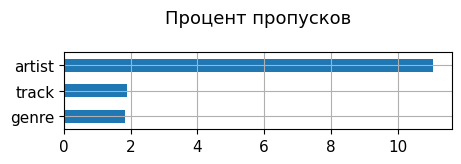

In [8]:
try:
    (
        (df.isna().mean()*100)
        .to_frame()
        .rename(columns={0:'space'})
        .query('space > 0')
        .sort_values(by='space', ascending=True)
        .plot(kind='barh', figsize=(5, 1), legend=False, fontsize=11, grid=True)
        .set_title('Процент пропусков' + "\n", fontsize=13)    
    );    
except:
    print('Пропусков нет.')

Заменим пропуски на `unknown`, предварительно создав копию изначального датафрейма.

In [9]:
old_df = df.copy()

for column in ['track', 'artist', 'genre']:
    df[column] = df[column].fillna('unknown') 

### 3.3 Обработка дубликатов
**Проверим наличие явных дубликатов в данных.**

In [10]:
df.duplicated().sum()

3826

Относительно наших данных их мало, удалим их.

In [11]:
df = df.drop_duplicates().reset_index(drop=True) 

**Проверим наличие неявных дубликатов в столбце `genre`.**

Выведем список уникальных названий жанров, отсортированный в алфавитном порядке.

In [12]:
df['genre'].sort_values().unique()

array(['acid', 'acoustic', 'action', 'adult', 'africa', 'afrikaans',
       'alternative', 'alternativepunk', 'ambient', 'americana',
       'animated', 'anime', 'arabesk', 'arabic', 'arena',
       'argentinetango', 'art', 'audiobook', 'author', 'avantgarde',
       'axé', 'baile', 'balkan', 'beats', 'bigroom', 'black', 'bluegrass',
       'blues', 'bollywood', 'bossa', 'brazilian', 'breakbeat', 'breaks',
       'broadway', 'cantautori', 'cantopop', 'canzone', 'caribbean',
       'caucasian', 'celtic', 'chamber', 'chanson', 'children', 'chill',
       'chinese', 'choral', 'christian', 'christmas', 'classical',
       'classicmetal', 'club', 'colombian', 'comedy', 'conjazz',
       'contemporary', 'country', 'cuban', 'dance', 'dancehall',
       'dancepop', 'dark', 'death', 'deep', 'deutschrock', 'deutschspr',
       'dirty', 'disco', 'dnb', 'documentary', 'downbeat', 'downtempo',
       'drum', 'dub', 'dubstep', 'eastern', 'easy', 'electronic',
       'electropop', 'emo', 'entehno', '

Приссутствуют дубликаты: hip, hop, hip-hop. Заменим их на `hiphop`.

In [13]:
df['genre'] = df['genre'].replace(['hip','hop','hip-hop'], 'hiphop')

### 3.4 Общий ущерб

In [14]:
print('Процент удалённых значений:', (old_df.shape[0] - df.shape[0]) * 100 / old_df.shape[0])

Процент удалённых значений: 5.879008589560381


<div style="border:solid steelblue 5px; padding: 30px">
   <p>
        <b>Результаты обработки данных:</b>
        <ol>
        <li>Переименованы столбцы.</li>
        <li>Обработаны пропуски.</li>
        <li>Обработаны дубликаты.</li>
        </ol>
        <b>Процент удалённых значений: 5.9%.</b>
   </p>  
</div>

## 4 Проверка гипотез
### 4.1 Активность пользователей зависит от дня недели. Причём в Москве и Петербурге это проявляется по-разному.
Оценим активность пользователей в каждом городе. 

In [15]:
def activity_plot(column, figsize, title, ylabel):
    df.groupby(column)['time'].count().plot(grid=True, kind='barh', figsize=(9, figsize), legend=False)
    plt.title('Активность пользователей в ' + title + "\n", fontsize = 13)
    plt.xlabel('Количество прослушиваний', fontsize = 11)
    plt.ylabel(ylabel, fontsize = 11)
    plt.show()

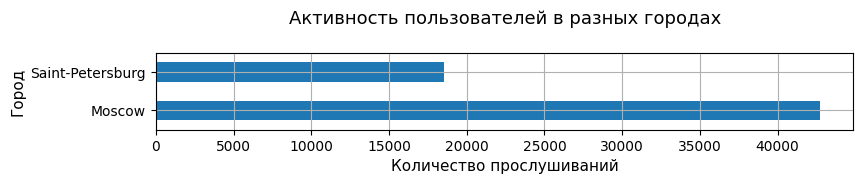

In [16]:
activity_plot(column='city', figsize=1, title='разных городах', ylabel='Город')

**В Москве прослушиваний больше, чем в Петербурге. Но это не значит, что московские пользователи чаще слушают музыку, ведь самих пользователей в Москве больше.**

Оценим активность пользователей в разные дни недели.

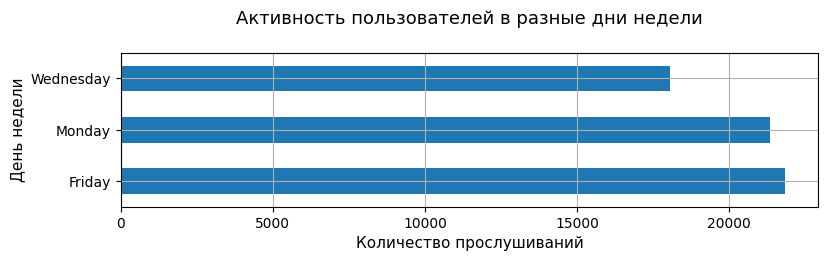

In [17]:
activity_plot(column='day', figsize=2, title='разные дни недели', ylabel='День недели')

**В среднем пользователи из двух городов менее активны по средам.**

Рассмотрим каждый город по отдельности.

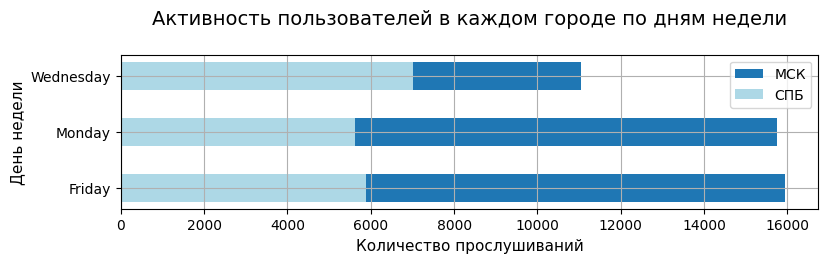

In [18]:
msk_df = df[df['city'] == 'Moscow']
spb_df = df[df['city'] == 'Saint-Petersburg']

day_msk_df = msk_df.pivot_table(index='day', values='user_id', aggfunc='count')
day_spb_df = spb_df.pivot_table(index='day', values='user_id', aggfunc='count')

fig, ax = plt.subplots(figsize=(9, 2))
width = 0.5
ax.barh(day_msk_df.index, day_msk_df['user_id'], width, label='МСК')
ax.barh(day_spb_df.index, day_spb_df['user_id'], width, label='СПБ', color='lightblue')
ax.legend(loc='upper right', prop={'size': 10}) 
ax.grid()
    
size = 11
plt.title('Активность пользователей в каждом городе по дням недели' + "\n", size=14)
plt.xlabel('Количество прослушиваний', size=size)
plt.ylabel('День недели', size=size)
plt.show()

<div style="border:solid steelblue 5px; padding: 30px">
   <p>
       <b>Гипотеза подтвердилась:</b>
        <li>В Москве пик прослушиваний приходится на понедельник и пятницу, а в среду заметен спад.</li>
        <li>В Петербурге, наоборот, больше слушают музыку по средам. Активность в понедельник и пятницу здесь почти в равной мере уступает среде.</li>
   </p>  
</div>

### 4.2 В понедельник утром в Москве преобладают одни жанры, а в Петербурге — другие. Так же и вечером пятницы преобладают разные жанры — в зависимости от города.
Выведем 10 самых популярных жанров в понедельник утром в Москве.

In [19]:
def genres_plot(df=msk_df, day='Monday', time1='07:00', time2='11:00', title='понедельник утром в Москве'):
    (
        df
        .query('day == @day & time > @time1 & time < @time2')
        .groupby('genre')['genre'].count()
        .sort_values(ascending=False)[:10][::-1]
        .plot(grid=True, kind='barh', figsize=(13, 3), legend=False)
    )
    plt.title('Топ-10 жанров в ' + title + "\n", fontsize = 16)
    plt.xlabel('Количество прослушиваний', fontsize = 13)
    plt.ylabel('Жанр', fontsize = 13)
    plt.show()

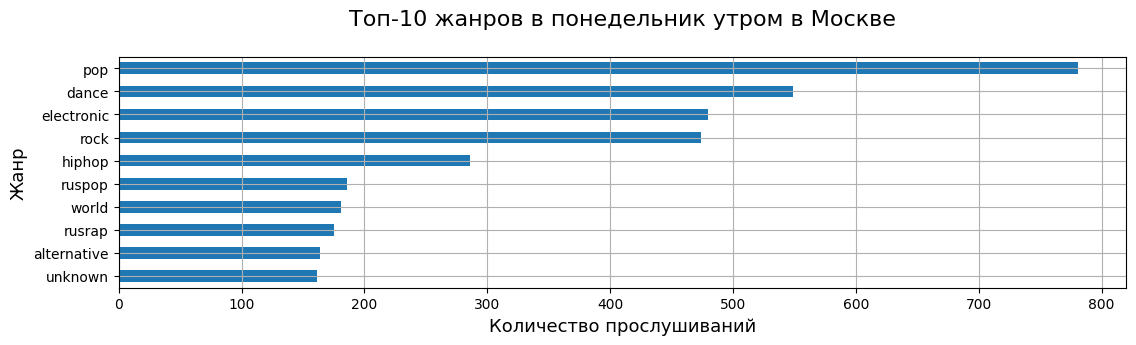

In [20]:
genres_plot()

Выведем 10 самых популярных жанров в понедельник утром в Петербурге.

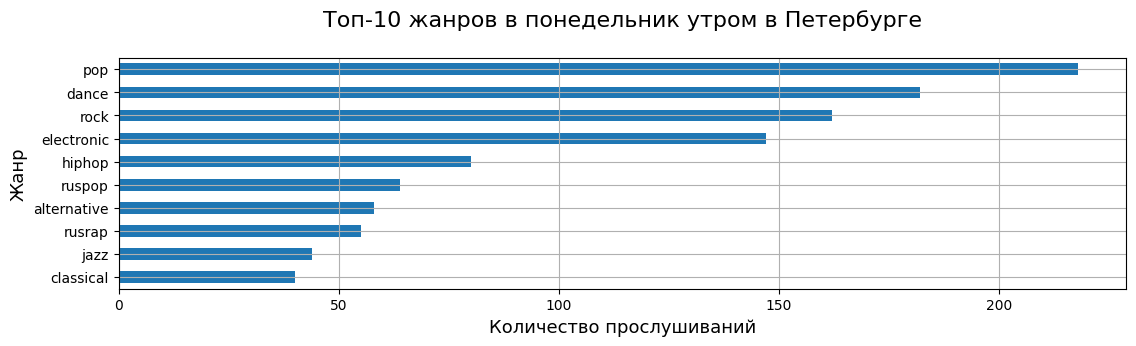

In [21]:
genres_plot(df=spb_df, title='понедельник утром в Петербурге')

Выведем 10 самых популярных жанров в пятницу вечером в Москве.

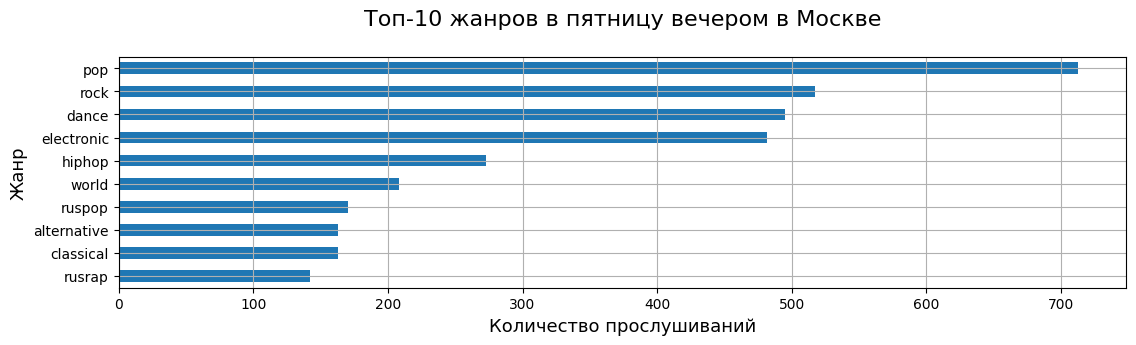

In [22]:
genres_plot(day='Friday', time1='17:00', time2='23:00', title='пятницу вечером в Москве')

Выведем 10 самых популярных жанров в пятницу вечером в Петербурге.

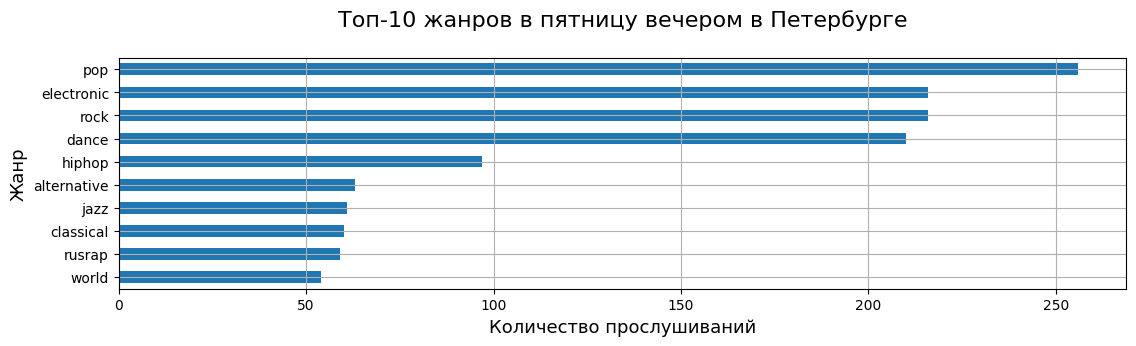

In [23]:
genres_plot(df=spb_df, day='Friday', time1='17:00', time2='23:00', title='пятницу вечером в Петербурге')

<div style="border:solid steelblue 5px; padding: 30px">
   <p>
       <b>Если сравнить топ-10 жанров в понедельник утром, можно сделать такие выводы:</b>
        <li>В Москве и Петербурге слушают похожую музыку. Единственное отличие — в московский рейтинг вошёл жанр “world”, а в петербургский — джаз и классика.</li>
        <li>В Москве пропущенных значений оказалось так много, что значение "unknown" заняло десятое место среди самых популярных жанров. Значит, пропущенные значения занимают существенную долю в данных и угрожают достоверности исследования.</li><br>
        <b>Вечер пятницы не меняет эту картину. Некоторые жанры поднимаются немного выше, другие спускаются, но в целом топ-10 остаётся тем же самым.</b> <br><br>
       <b>Таким образом, вторая гипотеза подтвердилась лишь частично:</b>
       <li>Пользователи слушают похожую музыку в начале недели и в конце.</li>
       <li>Разница между Москвой и Петербургом не слишком выражена. В Москве чаще слушают русскую популярную музыку, в Петербурге — джаз.</li>
       <b>Однако пропуски в данных ставят под сомнение этот результат. В Москве их так много, что рейтинг топ-10 мог бы выглядеть иначе, если бы не утерянные  данные о жанрах.</b>
   </p>  
</div>

### 4.3 Москва и Петербург предпочитают разные жанры музыки. В Москве чаще слушают поп-музыку, в Петербурге — русский рэп.
Выведем 10 самых популярных жанров в Москве.

In [24]:
def genres_plot_2(df, title):
    (
        df
        .groupby('genre')['genre'].count()
        .sort_values(ascending=False)[:10][::-1]
        .plot(grid=True, kind='barh', figsize=(13, 3), legend=False)
    )
    plt.title('Топ-10 жанров в ' + title + "\n", fontsize = 16)
    plt.xlabel('Количество прослушиваний', fontsize = 13)
    plt.ylabel('Жанр', fontsize = 13)
    plt.show()

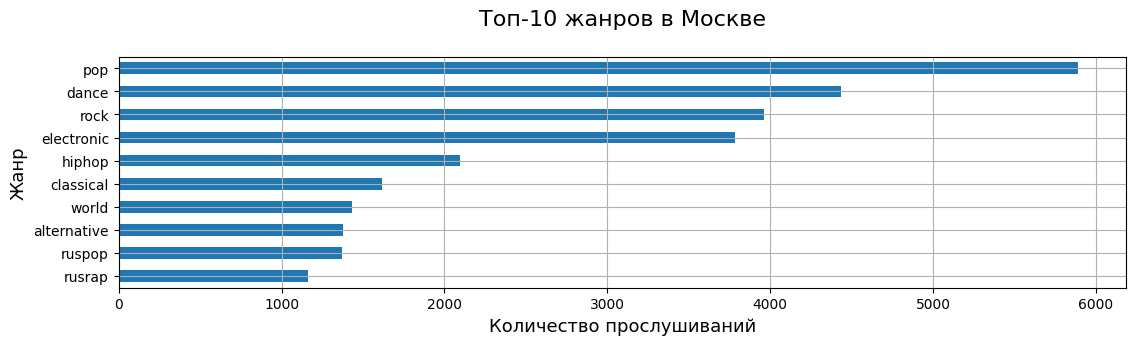

In [25]:
genres_plot_2(df=msk_df, title='Москве')

Выведем 10 самых популярных жанров в Петербурге.

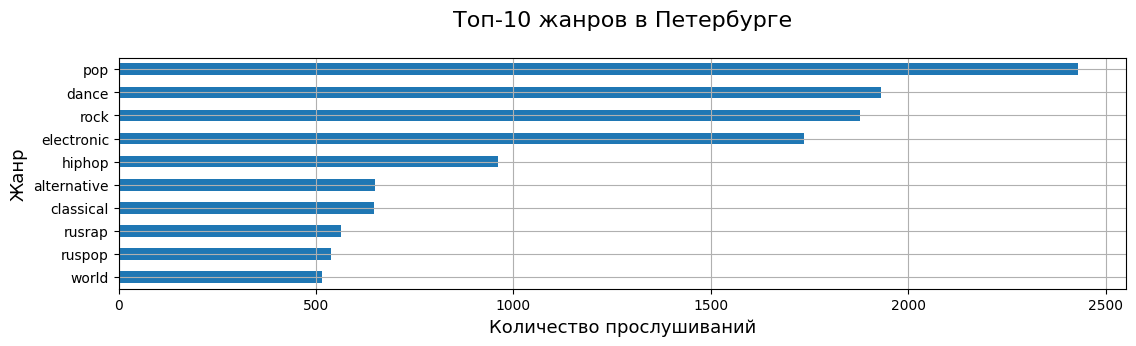

In [26]:
genres_plot_2(df=spb_df, title='Петербурге')

<div style="border:solid steelblue 5px; padding: 30px">
   <p>
       <b>Гипотеза частично подтвердилась:</b>
        <li>Поп-музыка — самый популярный жанр в Москве, как и предполагала гипотеза. Более того, в топ-10 жанров встречается близкий жанр — русская популярная музыка.</li>
        <li>Вопреки ожиданиям, рэп одинаково популярен в Москве и Петербурге.</li>
   </p>  
</div>

## 5 Общий вывод

<div style="border:solid steelblue 5px; padding: 30px">
   <p>
        <b>Проделано:</b>
        <ol><li>Изучена общая информацию о данных.</li>
        <li>Проведена предподготовка данных: переименованы столбцы, обработаны пропуски и дубликаты.</li>
        <li>Проверены гипотезы.</li>
        </ol>
        <b>Выявлено:</b>
        <li>Первая гипотеза подтвердилась. День недели по-разному влияет на активность пользователей в Москве и Петербурге.</li>
        <li>Вторая гипотеза подтвердилась частично. Музыкальные предпочтения не сильно меняются в течение недели — будь то Москва или Петербург. Небольшие различия заметны в начале недели, по понедельникам: в Москве слушают музыку жанра “world”, в Петербурге — джаз и классику. Этот результат мог оказаться иным, если бы не пропуски в данных.</li>
        <li>Третья гипотеза подтвердилась частично. Во вкусах пользователей Москвы и Петербурга больше общего чем различий. Вопреки ожиданиям, предпочтения жанров в Петербурге напоминают московские.</li>
   </p>  
</div>